## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.color import rgb2ycbcr
from torch.utils.data import Dataset, DataLoader

## Loading Image

In [2]:
image = plt.imread('baby.png')
image = rgb2ycbcr(image)[:, :, 0]

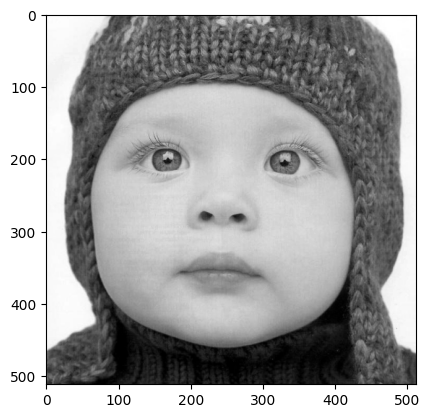

In [3]:
plt.imshow(image, cmap='gray')

## Generating Dataset

In [8]:
class PixelDataset(Dataset):
    def __init__(self, image):
        x1_rng = np.linspace(-1, 1, image.shape[0])
        x2_rng = np.linspace(-1, 1, image.shape[1])
        x1, x2 = np.meshgrid(x1_rng, x2_rng)
        x1 = x1.reshape(-1, 1)
        x2 = x2.reshape(-1, 1)
        self.X = np.concatenate((x1, x2), axis=-1)
        self.Y = image.reshape(-1) / 255.0

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

## Defining The Model

### 1. Naive Model

In [9]:
class ImageNeRF(nn.Module):
    def __init__(self, n_layers, hidden_dim):
        super().__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(nn.Linear(2, hidden_dim))
                layers.append(nn.ReLU())
            elif i == n_layers - 1:
                layers.append(nn.Linear(hidden_dim, 1))
                layers.append(nn.Sigmoid())
            else:
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

### 2. Model with Positional Encoding

In [67]:
class ImageNeRF(nn.Module):
    def __init__(self, n_layers, hidden_dim, L=10):
        super().__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(nn.Linear(4*L, hidden_dim))
                layers.append(nn.ReLU())
            elif i == n_layers - 1:
                layers.append(nn.Linear(hidden_dim, 1))
                layers.append(nn.Sigmoid())
            else:
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)

        self.encoder = lambda x: torch.stack([torch.sin((2**i) * x) for i in range(L)] +
                                           [torch.cos((2**i) * x) for i in range(L)], dim=-1)
        
    def forward(self, x):
        x_encoded = torch.concat((self.encoder(x[:, 0]), self.encoder(x[:, 1])), dim=-1)
        return self.net(x_encoded)

In [68]:
model = ImageNeRF(n_layers=5, hidden_dim=256)

In [69]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
num_pixels = image.shape[0] * image.shape[1]
print(f'# Params: {num_params}, # Pixel: {num_pixels}, Ratio: {100*(num_params/num_pixels):.2f}%')

# Params: 208129, # Pixel: 262144, Ratio: 79.39%


## Training The Model

In [70]:
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [71]:
dataset = PixelDataset(image)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [18]:
for epoch in range(30):
    mean_loss = 0.0
    for x, y in dataloader:
        y_hat = model(x)
        loss = loss_fn(y_hat.squeeze(), y.squeeze())
        mean_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    mean_loss /= len(dataloader)
    print(f'EPOCH: {epoch}, LOSS: {mean_loss:.5f}')

EPOCH: 0, LOSS: 0.05846
EPOCH: 1, LOSS: 0.04268
EPOCH: 2, LOSS: 0.03914
EPOCH: 3, LOSS: 0.03664
EPOCH: 4, LOSS: 0.03554
EPOCH: 5, LOSS: 0.03476
EPOCH: 6, LOSS: 0.03351
EPOCH: 7, LOSS: 0.03315
EPOCH: 8, LOSS: 0.03250
EPOCH: 9, LOSS: 0.03211
EPOCH: 10, LOSS: 0.03167
EPOCH: 11, LOSS: 0.03131
EPOCH: 12, LOSS: 0.03071
EPOCH: 13, LOSS: 0.03039
EPOCH: 14, LOSS: 0.03025
EPOCH: 15, LOSS: 0.02998
EPOCH: 16, LOSS: 0.02981
EPOCH: 17, LOSS: 0.02964
EPOCH: 18, LOSS: 0.02938
EPOCH: 19, LOSS: 0.02911
EPOCH: 20, LOSS: 0.02909
EPOCH: 21, LOSS: 0.02891
EPOCH: 22, LOSS: 0.02866
EPOCH: 23, LOSS: 0.02853
EPOCH: 24, LOSS: 0.02833
EPOCH: 25, LOSS: 0.02831
EPOCH: 26, LOSS: 0.02817
EPOCH: 27, LOSS: 0.02795
EPOCH: 28, LOSS: 0.02789
EPOCH: 29, LOSS: 0.02772


In [72]:
for epoch in range(30):
    mean_loss = 0.0
    for x, y in dataloader:
        y_hat = model(x)
        loss = loss_fn(y_hat.squeeze(), y.squeeze())
        mean_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    mean_loss /= len(dataloader)
    print(f'EPOCH: {epoch}, LOSS: {mean_loss:.5f}')

EPOCH: 0, LOSS: 0.04054
EPOCH: 1, LOSS: 0.02639
EPOCH: 2, LOSS: 0.02255
EPOCH: 3, LOSS: 0.02046
EPOCH: 4, LOSS: 0.01891
EPOCH: 5, LOSS: 0.01785
EPOCH: 6, LOSS: 0.01694
EPOCH: 7, LOSS: 0.01631
EPOCH: 8, LOSS: 0.01573
EPOCH: 9, LOSS: 0.01526
EPOCH: 10, LOSS: 0.01487
EPOCH: 11, LOSS: 0.01445
EPOCH: 12, LOSS: 0.01415
EPOCH: 13, LOSS: 0.01384
EPOCH: 14, LOSS: 0.01358
EPOCH: 15, LOSS: 0.01333
EPOCH: 16, LOSS: 0.01316
EPOCH: 17, LOSS: 0.01293
EPOCH: 18, LOSS: 0.01277
EPOCH: 19, LOSS: 0.01254
EPOCH: 20, LOSS: 0.01236
EPOCH: 21, LOSS: 0.01219
EPOCH: 22, LOSS: 0.01206
EPOCH: 23, LOSS: 0.01192
EPOCH: 24, LOSS: 0.01178
EPOCH: 25, LOSS: 0.01168
EPOCH: 26, LOSS: 0.01153
EPOCH: 27, LOSS: 0.01143
EPOCH: 28, LOSS: 0.01136
EPOCH: 29, LOSS: 0.01120


## Evaluating

In [73]:
x = torch.tensor(dataset.X, dtype=torch.float32)

In [74]:
with torch.no_grad():
    y_hat = model(x)

In [75]:
image_hat = y_hat.view(image.shape).numpy()

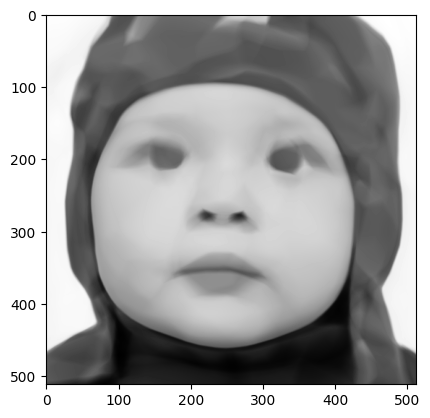

In [26]:
plt.imshow(image_hat, cmap='gray')

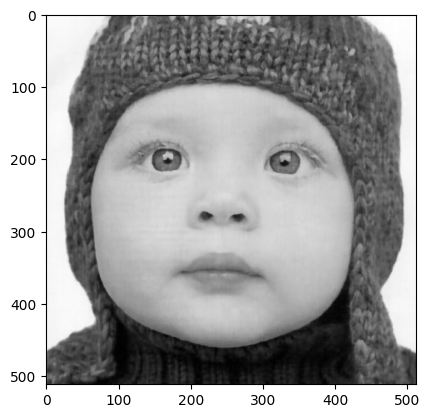

In [92]:
plt.imshow(image_hat, cmap='gray')

Text(0.5, 1.0, 'GT')

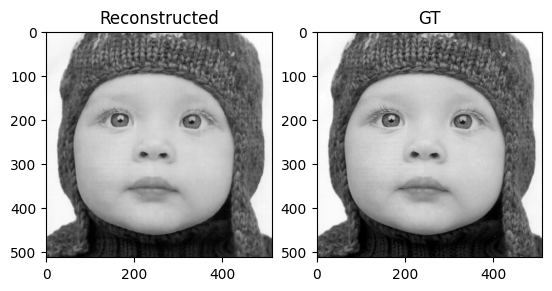

In [93]:
_, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(image_hat, cmap='gray')
ax[0].set_title('Reconstructed')
ax[1].imshow(image, cmap='gray')
ax[1].set_title('GT')

## Resize

In [113]:
sf = 0.7
new_shape = (int(image.shape[0] * sf), int(image.shape[1] * sf))

In [114]:
x1_rng = np.linspace(-1, 1, new_shape[0])
x2_rng = np.linspace(-1, 1, new_shape[1])
x1, x2 = np.meshgrid(x1_rng, x2_rng)
x1 = x1.reshape(-1, 1)
x2 = x2.reshape(-1, 1)
x = np.concatenate((x1, x2), axis=-1)

In [115]:
x = torch.tensor(x, dtype=torch.float32)

In [116]:
with torch.no_grad():
    y_hat = model(x)

In [117]:
image_hat = y_hat.view(new_shape).numpy()

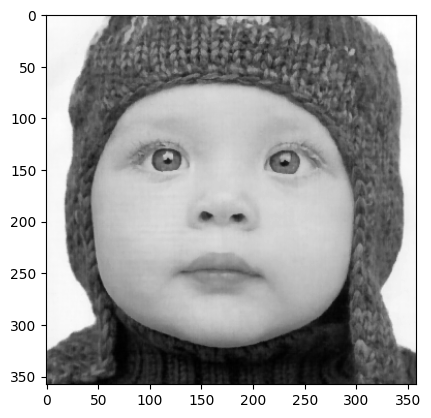

In [118]:
plt.imshow(image_hat, cmap='gray')